In [57]:
import os
import pandas as pd
import collections
import pickle
#import cPickle
import _pickle as cPickle

import scipy
from scipy import sparse
import numpy as np

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import nltk
import nltk.data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize,sent_tokenize

import re
import string
import time
import codecs
from Bio import Medline

import gensim
from gensim import corpora, models, similarities
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec, Word2Vec, CoherenceModel
from gensim.summarization import summarize

from collections import defaultdict

import pyLDAvis.gensim

import GapStatistics
import time

import bokeh

In [58]:
# Configurations and Variable Definitions

In [59]:
# Configuration: Data file name (it should be placed in the same ditrectory as the notebook file)
DATA_FILE = '/data/pubmed_result_6517_0900_"Pain"[Mesh]_Medline_EnglishOnlyFilter.txt'
#DATA_FILE = DATA_FILE = '/data/pubmedtext.txt'
#test variables
# test_pmid = '27179337'
test_pmid = '28324318'

In [60]:
# constant variables
CLEANED_ABSTRACT_COL = 'cleaned_abstract'
SUMMARY_ABSTRACT_COL = 'summary_abstract'
CLEANED_MINIMAL_ABSTRACT_COL = 'cleaned_minimal_abstract'
TOKENIZED_CLEAN_ABS_COL = 'tokenized_c_abstract'
TOKENIZED_RAW_ABS_COL = 'tokenized_r_abstract'
TOKEN_COUNT_RAW_ABS_COL = 'token_count_r_abstract'
TOKEN_COUNT_CLEAN_ABS_COL = 'token_count_c_abstract'
TOKEN_COUNT_Unq_CLEAN_ABS_COL = 'token_count_unq_c_abstract'

In [61]:
# Input File Processing

In [62]:
#Dictionary of medline terms: https://www.nlm.nih.gov/bsd/mms/medlineelements.html
#Note that this differs from above by removing grants and affiliations in an effort to minimize exceptions
def read_medline_data_raw(filename):
    recs = Medline.parse(open(filename, 'r'))
    text = pd.DataFrame(columns = ["pmid", "articletitle", "journaltitle", "abstract"])
    count = 0
    for rec in recs:
        try:
            pmid = rec['PMID']
            atitle = rec["TI"]
            jtitle = rec["JT"]
            pubdate = rec["DP"]
            abstr = rec["AB"]
            text = text.append(pd.DataFrame([[pmid,atitle, jtitle,pubdate, abstr]],
                columns=["pmid", "articletitle", "journaltitle", "pubdate", "abstract"]),ignore_index=True, verify_integrity=True)            
        except:
            pass
    text.set_index(text.pmid)
    return text

In [63]:
# get the Data file path

print("Cell started at: " + time.strftime("%c"))
try:
    approot = os.path.dirname(os.path.realpath('__file__'))
except NameError:  # if it is the main script, not a module
    import sys
    approot = os.path.dirname(os.path.abspath(sys.argv[0]))
DATA_PATH = approot + DATA_FILE

# Read in MEDLINE formatted text
%time papers = read_medline_data_raw(DATA_PATH)
papers.to_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update')
papers.to_csv('data/papers_pain_EngFilter_6_5_2017_raw_oct17update.csv')
print("Cell completed at: " + time.strftime("%c"))

Cell started at: Sun May 27 06:03:49 2018
CPU times: user 42min 3s, sys: 2min 18s, total: 44min 22s
Wall time: 44min 22s
Cell completed at: Sun May 27 06:48:20 2018


In [64]:
papers = pd.read_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update')

In [65]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202053 entries, 0 to 202052
Data columns (total 5 columns):
abstract        202053 non-null object
articletitle    202053 non-null object
journaltitle    202053 non-null object
pmid            202053 non-null object
pubdate         202053 non-null object
dtypes: object(5)
memory usage: 7.7+ MB


In [66]:
pubdatevalues = papers.pubdate.unique()
#pubdatevalues.tofile("pubdatevalues.csv", sep=',') Examine range of pubdates manually in csv

In [67]:
papers['pubdate_dtformat'] = pd.to_datetime(papers.pubdate, format='%Y', exact=False)
papers['pubyear'] = pd.DatetimeIndex(papers['pubdate_dtformat']).year
papers=papers.drop('pubdate_dtformat', axis=1)

In [68]:
papers.tail(10)

,abstract,articletitle,journaltitle,pmid,pubdate,pubyear
202043,AIMS: To conduct a systematic review to determ...,Systematic Review and Meta-analysis of the Eff...,Journal of oral & facial pain and headache,27472529,Summer 2016,2016
202044,AIMS: To assess the influence of clenching sid...,Ipsilateral Molar Clenching Induces Less Pain ...,Journal of oral & facial pain and headache,27472527,Summer 2016,2016
202045,AIMS: To determine if pressure pain thresholds...,The Effects of Mandibular Advancement Device o...,Journal of oral & facial pain and headache,27472526,Summer 2016,2016
202046,AIMS: To evaluate the transient effects of ort...,Transient Pain Following Orthodontic Fixed App...,Journal of oral & facial pain and headache,27472525,Summer 2016,2016
202047,"AIMS: To analyze the methodologic quality, sum...",The Effectiveness of Physiotherapy in the Mana...,Journal of oral & facial pain and headache,27472523,Summer 2016,2016
202048,AIMS: To investigate the relationship between ...,Circulating Omentin-1 and Chronic Painful Temp...,Journal of oral & facial pain and headache,27472522,Summer 2016,2016
202049,AIMS: To evaluate whether a biobehavioral inte...,Temporomandibular Disorder Diagnostic Groups A...,Journal of oral & facial pain and headache,27472521,Summer 2016,2016
202050,We propose that trigger-point dry needle (TrP-...,Trigger-Point Dry Needling for the SOF Medic.,Journal of special operations medicine : a pee...,28088815,Winter 2016,2016
202051,"Erythrocytosis, or increased red blood cell ma...","Secondary Hypertension, Erythrocytosis, and Un...",Journal of special operations medicine : a pee...,28088811,Winter 2016,2016
202052,PURPOSE: Juvenile idiopathic arthritis (JIA) i...,The Effects of Orthopedic Manual Physical Ther...,Pediatric physical therapy : the official publ...,27661250,Winter 2016,2016


In [69]:
papers.loc[papers['pubdate']=='2011 Nov']

,abstract,articletitle,journaltitle,pmid,pubdate,pubyear
54329,BACKGROUND: Addiction is a feared complication...,Validation and usefulness of the Danish versio...,Acta anaesthesiologica Scandinavica,22092128,2011 Nov,2011
54332,AIM: Prevalence rates for deliberate self-harm...,Deliberate self-harm by Taiwanese adolescents.,"Acta paediatrica (Oslo, Norway : 1992)",21575057,2011 Nov,2011
54333,AIM: To establish to what extent somatic cause...,Recurrent abdominal pain in 200 children: soma...,"Acta paediatrica (Oslo, Norway : 1992)",21575052,2011 Nov,2011
54334,"AIM: First, to what extent do general paediatr...",Paediatric functional abdominal pain: signific...,"Acta paediatrica (Oslo, Norway : 1992)",21557765,2011 Nov,2011
54335,AIM: To compare the efficacy of sublingual mid...,Comparison of a morphine and midazolam combina...,"Acta paediatrica (Oslo, Norway : 1992)",21480984,2011 Nov,2011
54337,INTRODUCTION: D-Dimer (DD) has been described ...,Cost associated with D-Dimer screening for acu...,Advances in therapy,22009630,2011 Nov,2011
54338,BACKGROUND: Many analgesic modalities have bee...,Investigating the efficacy of vibration anesth...,Aesthetic surgery journal,22001341,2011 Nov,2011
54344,OBJECTIVE: The purpose of this article is to s...,Groin pain beyond the hip: how anatomy predisp...,AJR. American journal of roentgenology,22021514,2011 Nov,2011
54348,BACKGROUND: Myeloperoxidase (MPO) is proposed ...,Myeloperoxidase in the diagnosis of acute coro...,American heart journal,22093206,2011 Nov,2011
54350,UNLABELLED: Patients frequent take acetaminoph...,Dental pain as a risk factor for accidental ac...,The American journal of emergency medicine,20951526,2011 Nov,2011


In [70]:
papers.journaltitle.nunique()

5333

In [71]:
papers.to_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update_Mar18year')
papers = pd.read_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update_Mar18year')

In [72]:
# Text Cleanup & Tokenization

In [73]:
## Remove "all-caps:" section headers, punctuation marks, numbers, and option for words in all capital letters

In [74]:
# This function will use regular expressions to remove all:
#  (1) words/phrases in all caps followed by :, (if filter_all_caps = True, eveything all-caps will be removed)     
#  (2) numbers
#  (3) one letter words (such as n or p or other mathematical symbols)
#  (4) punctuation marks
# return value is the list of all filtered words (except for numbers), and the clean abstracts

# A utility function for flattening the lists
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, str):
            for sub in flatten(el):
                yield sub
        else:
            yield el

# Filter text as described above            
def filterText(abstracts, filter_all_caps = False):    
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    if filter_all_caps:
        pattern = regex.pattern + r"|\b[A-Z]{2,}|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    else:
        pattern = regex.pattern + r"|(((\s|^)[A-Z]{2,}(,)*)*)(\s|^)(\b[A-Z]{2,}):|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    
    #The list of all filtered words (except for numbers)
    # convert to a falttened set for faster results
    all_filtered_series = abstracts.apply(lambda d: re.findall(pattern, d))
    all_filtered = set(flatten(all_filtered_series.tolist()))
    non_digit_filtered = [y for y in all_filtered if not y.isdigit()]
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '', d))
    abstracts = abstracts.apply(lambda d: re.sub('s-s', '', d))
    
    return abstracts, non_digit_filtered

In [75]:
## Remove stop words

In [76]:
# This function will replace all the stop words, it also gets rid of the whitespaces
def removeWord(text, stop_list):
    new_text = []
    
    #first convert to a list
    text_list = str.split(text)
    
    #check for stop words
    for x in text_list:
        if x not in stop_list:
            new_text.append(x)
    
    #convert back to string
    new_text_str = ' '.join(new_text)
    
    return new_text_str

# This function will remove stop words using NLTK stop word list
# It will return processed abstracts and stop word list
def removeStopWords(abstracts):         
    # use NLTK's default stop word list
    stop_set = set(stopwords.words('english'))
    
    # find all stop words and remove them
    abstracts = abstracts.apply(lambda d: removeWord(d, stop_set))
    
    return abstracts, stop_set

In [77]:
## Convert to lower case, tokenize

In [78]:
# This fuction will convert everything to lower-case
def changeToLowerCase(abstracts):  
    abstracts = abstracts.apply(lambda d: d.lower())
    return abstracts

In [79]:
# This function will tokenize all sentences
def tokenizeAbstracts(abstracts):  
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = abstracts.apply(lambda d: tokenizer.tokenize(d))
    return tokens

In [80]:
## Combine Preprocess Functions

In [81]:
def preprocessAbstracts(abstracts):    
    # Remove all-caps words, numbers, 1-letter words, punctuation marks 
    abstracts, filtered = filterText(abstracts, filter_all_caps= False)
    
    # conevrt to lower-case
    abstracts = changeToLowerCase(abstracts)
    
    # Remove stop words
    abstracts, stop_list = removeStopWords(abstracts)
    filtered = filtered + list(stop_list)
    
    # tokenize
    tokens = tokenizeAbstracts(abstracts)
    
    return abstracts, tokens, filtered

In [82]:
# This can be helpful for word2vec models that need minimal preprocessing
def minimallyPreprocessAbstracts(abstracts):
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    pattern = regex.pattern + r"|[0-9.]+" 
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '#NUM', d))
    abstracts = abstracts.apply(lambda d: re.sub('s-s', '', d))
    return abstracts

In [83]:
## Apply preprocessing

In [84]:
# preprocess the abstracts
papers[CLEANED_ABSTRACT_COL], papers[TOKENIZED_CLEAN_ABS_COL], filtered = preprocessAbstracts(papers.abstract)
papers[CLEANED_MINIMAL_ABSTRACT_COL] = minimallyPreprocessAbstracts(papers.abstract)
%time papers[TOKENIZED_RAW_ABS_COL] = tokenizeAbstracts(papers.abstract)
# pre-compute the token counts
papers[TOKEN_COUNT_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_RAW_ABS_COL] =papers[TOKENIZED_RAW_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_Unq_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(set(text)))

CPU times: user 13 s, sys: 1.14 s, total: 14.1 s
Wall time: 14.1 s


In [85]:
#Show list of filtered terms
print(filtered)

['', 'QUESTIONS', 'ROI', 'CONSIDERATIONS', ' MAIN OUTCOME', 'ISRCTN', ' QUALITY OF', 'IINTERPRETATION', ' APPLICATION TO CLINICAL', 'BC', ' CLIENT', 'PUFA', 'ND', 'PAG', 'TRAP', 'TS', 'PAIN', 'UA', ' DESIGN OF', 'COURSE', 'MEDLINE', ' LIMITATIONS, REASONS FOR', 'EDUCATION', ' EVALUATION', ' AIM OF', ' RESULTS AND FINAL', ' LITERATURE', 'UCLA', ' SUBJECTS OR', ' NEW', 'NSCLBP', 'CCP', 'CFS', 'SD', 'TFCC', ' CONCLUSIONS IN PAPER', 'CM', 'NURSING', 'SOLUTIONS', ' PATIENTS, PARTICIPANTS, AND', ' NEW OR UNIQUE INFORMATION', ' FIFTEEN YEARS AND', 'FS', ' DISCUSSIONS AND', ' METHODS AND', 'NEW', ' FUNDED', 'PRESENTING', ' FOUR', ' ANESTHETIC', ' CASUISTIC AND', ' CONCLUSIONS AND PRACTICAL', ' DATA EXTRACTION AND', ' SUMMARY OF', 'FVIII', ' MEASURES,', 'TBPE', ' RISK', ' CONCLUSION AND POTENTIAL', ' CLINCIAL', ' SECONDARY', 'TIVA', 'OBJECTIVE OF THE', 'ADDS', 'PACU', ' LEARNING FROM THE', 'MEASUREMENT', ' PRINCIPAL', 'VARIABLES', 'SAMPLES', 'NG', 'SAFETY', 'PREVENTION', ' BASIC RESEARCH DESIGN

In [86]:
papers.to_pickle('data/papapers_pain_EngFilter_6_5_2017_raw_preprocessed_oct17update_Mar18years')
%time papers = pd.read_pickle('data/papapers_pain_EngFilter_6_5_2017_raw_preprocessed_oct17update_Mar18years')

CPU times: user 15.1 s, sys: 2.75 s, total: 17.8 s
Wall time: 17.8 s


In [87]:
papers

,abstract,articletitle,journaltitle,pmid,pubdate,pubyear,cleaned_abstract,tokenized_c_abstract,cleaned_minimal_abstract,tokenized_r_abstract,token_count_c_abstract,token_count_r_abstract,token_count_unq_c_abstract
0,pH-sensitive nonionic surfactant vesicles (nio...,pH-sensitive niosomes: Effects on cytotoxicity...,Journal of enzyme inhibition and medicinal che...,28114822,2017 Dec,2017,ph-sensitive nonionic surfactant vesicles nios...,"[ph, sensitive, nonionic, surfactant, vesicles...",pH-sensitive nonionic surfactant vesicles #NUM...,"[pH, sensitive, nonionic, surfactant, vesicles...",114,162,90
1,BACKGROUND: The prevalence of migraine with co...,"Level of physical activity, well-being, stress...",The journal of headache and pain,28421374,2017 Dec,2017,prevalence migraine co-existing tension-type h...,"[prevalence, migraine, co, existing, tension, ...",BACKGROUND#NUM The prevalence of migraine with...,"[BACKGROUND, The, prevalence, of, migraine, wi...",228,347,80
2,BACKGROUND: Identification of subgroups of pat...,Identification of subgroups of patients with t...,The journal of headache and pain,28401498,2017 Dec,2017,identification subgroups patients different le...,"[identification, subgroups, patients, differen...",BACKGROUND#NUM Identification of subgroups of ...,"[BACKGROUND, Identification, of, subgroups, of...",183,292,110
3,BACKGROUND: Burning Mouth Syndrome (BMS) is a ...,Refractory burning mouth syndrome: clinical an...,The journal of headache and pain,28357703,2017 Dec,2017,burning mouth syndrome bms chronic pain condit...,"[burning, mouth, syndrome, bms, chronic, pain,...",BACKGROUND#NUM Burning Mouth Syndrome #NUMBMS#...,"[BACKGROUND, Burning, Mouth, Syndrome, BMS, is...",149,262,114
4,BACKGROUND: Despite their huge epidemiological...,Botulinum neurotoxin type A for the treatment ...,The journal of headache and pain,28324318,2017 Dec,2017,despite huge epidemiological impact primary he...,"[despite, huge, epidemiological, impact, prima...",BACKGROUND#NUM Despite their huge epidemiologi...,"[BACKGROUND, Despite, their, huge, epidemiolog...",113,168,85
5,BACKGROUND: Calcitonin gene-related peptide (C...,Calcitonin gene-related peptide and pain: a sy...,The journal of headache and pain,28303458,2017 Dec,2017,calcitonin gene-related peptide cgrp widely di...,"[calcitonin, gene, related, peptide, cgrp, wid...",BACKGROUND#NUM Calcitonin gene-related peptide...,"[BACKGROUND, Calcitonin, gene, related, peptid...",154,244,100
6,BACKGROUND: The aim of this study was to inves...,Increased levels of intramuscular cytokines in...,The journal of headache and pain,28243900,2017 Dec,2017,aim study investigate cytokine levels masseter...,"[aim, study, investigate, cytokine, levels, ma...",BACKGROUND#NUM The aim of this study was to in...,"[BACKGROUND, The, aim, of, this, study, was, t...",179,342,92
7,BACKGROUND: Cardiac cephalalgia (CC) is a rare...,Cardiac cephalalgia: one case with cortical hy...,The journal of headache and pain,28220375,2017 Dec,2017,cardiac cephalalgia cc rare disease occurring ...,"[cardiac, cephalalgia, cc, rare, disease, occu...",BACKGROUND#NUM Cardiac cephalalgia #NUMCC#NUM ...,"[BACKGROUND, Cardiac, cephalalgia, CC, is, a, ...",93,173,68
8,"BACKGROUND: In the emergency setting, non-trau...",Copeptin for risk stratification in non-trauma...,The journal of headache and pain,28197843,2017 Dec,2017,emergency setting non-traumatic headache benig...,"[emergency, setting, non, traumatic, headache,...",BACKGROUND#NUM In the emergency setting#NUM no...,"[BACKGROUND, In, the, emergency, setting, non,...",169,301,111
9,BACKGROUND: A better understanding of potentia...,The association of headache frequency with pai...,The journal of headache and pain,28185160,2017 Dec,2017,better understanding potential relationship mo...,"[better, understanding, potential, relationshi...",BACKGROUND#NUM A better understanding of poten...,"[BACKGROUND, A, better, understanding, of, pot...",176,278,81


In [88]:
#Test
print('Original Abstract: \n', papers.abstract[papers.pmid == test_pmid])
print('\nCleaned Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_ABSTRACT_COL])
print('\nTokenized Abstract: \n', papers.loc[papers.pmid == test_pmid, TOKENIZED_CLEAN_ABS_COL])
print('\nMinimally Processed Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_MINIMAL_ABSTRACT_COL])
papers[(papers.pmid == test_pmid)]

Original Abstract: 
 4    BACKGROUND: Despite their huge epidemiological...
Name: abstract, dtype: object

Cleaned Abstract: 
 4    despite huge epidemiological impact primary he...
Name: cleaned_abstract, dtype: object

Tokenized Abstract: 
 4    [despite, huge, epidemiological, impact, prima...
Name: tokenized_c_abstract, dtype: object

Minimally Processed Abstract: 
 4    BACKGROUND#NUM Despite their huge epidemiologi...
Name: cleaned_minimal_abstract, dtype: object


,abstract,articletitle,journaltitle,pmid,pubdate,pubyear,cleaned_abstract,tokenized_c_abstract,cleaned_minimal_abstract,tokenized_r_abstract,token_count_c_abstract,token_count_r_abstract,token_count_unq_c_abstract
4,BACKGROUND: Despite their huge epidemiological...,Botulinum neurotoxin type A for the treatment ...,The journal of headache and pain,28324318,2017 Dec,2017,despite huge epidemiological impact primary he...,"[despite, huge, epidemiological, impact, prima...",BACKGROUND#NUM Despite their huge epidemiologi...,"[BACKGROUND, Despite, their, huge, epidemiolog...",113,168,85


In [89]:
# Topic Modeling with LDA

In [90]:
## Create Corpus, Dictionary, and Related Text Constructs

In [91]:
# create a dictionary mapping words to ids
abstract_list = papers[TOKENIZED_CLEAN_ABS_COL].values
ca_gs_dictionary = corpora.Dictionary(abstract_list)

#remove extremes (similar to tf-idf)
ca_gs_dictionary.filter_extremes(no_below=1, no_above=0.8)
ca_gs_dictionary.compactify()

In [92]:
#convert the dictionary to a bag of words
ca_gs_corpus = [ca_gs_dictionary.doc2bow(words) for words in abstract_list]
# corpora.mmcorpus.MmCorpus.serialize('data/ca_gensim.mm', corpus)
ca_gs_tfidf = models.TfidfModel(ca_gs_corpus)

In [93]:
## Topic Modeling via LDA

In [94]:
### Determine optimal number of topics through coherence testing

In [95]:
def LDA_compute_coherence_values(dictionary, corpus, texts, limit):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(2, limit, 6):
        model = models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=5, 
                                                 workers=16)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [96]:
LDA_model_list, LDA_coherence_values = LDA_compute_coherence_values(dictionary=ca_gs_dictionary, corpus=ca_gs_corpus, texts=abstract_list, limit=50)

In [97]:
print(LDA_model_list)
print(LDA_coherence_values)

[<gensim.models.ldamulticore.LdaMulticore object at 0x7facb4f11630>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fac74886390>, <gensim.models.ldamulticore.LdaMulticore object at 0x7facb64482e8>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fac74e4bf28>, <gensim.models.ldamulticore.LdaMulticore object at 0x7facb4bdacc0>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fac757630f0>, <gensim.models.ldamulticore.LdaMulticore object at 0x7facb4e24278>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fac75a90cc0>]
[0.3561077301764383, 0.48411174907153137, 0.49234757790822486, 0.4798594232379245, 0.46387423506553555, 0.49627455094681966, 0.5102653500537135, 0.4862196372850324]


In [98]:
with open('LDA_model_list.pkl', 'wb') as f:
    pickle.dump(LDA_model_list, f)
    
with open('LDA_coherence_values.pkl', 'wb') as f:
    pickle.dump(LDA_coherence_values, f)

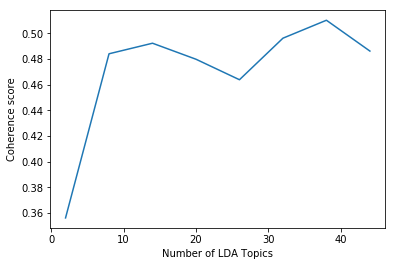

In [99]:
limit=50
x = range(2, limit, 6)
plt.plot(x, LDA_coherence_values)
plt.xlabel("Number of LDA Topics")
plt.ylabel("Coherence score")
# plt.legend(("LDA_coherence_values"), loc='best')
plt.show()

In [100]:
for m, cv in zip(x, LDA_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3561
Num Topics = 8  has Coherence Value of 0.4841
Num Topics = 14  has Coherence Value of 0.4923
Num Topics = 20  has Coherence Value of 0.4799
Num Topics = 26  has Coherence Value of 0.4639
Num Topics = 32  has Coherence Value of 0.4963
Num Topics = 38  has Coherence Value of 0.5103
Num Topics = 44  has Coherence Value of 0.4862


In [101]:
num_of_LDA_topics = 25 #Derived from coherence testing of topic counts from 2 to 50 for LDA

In [102]:
### Run LDA with 25 topics

In [103]:
# %time lda = models.LdaModel(ca_gs_corpus, num_topics=num_of_LDA_topics, id2word =ca_gs_dictionary, update_every=5, passes=100)
%time lda_mc = models.ldamulticore.LdaMulticore(corpus=ca_gs_corpus, num_topics=num_of_LDA_topics, id2word=ca_gs_dictionary, passes=100, workers=16)

CPU times: user 33min 36s, sys: 2min 25s, total: 36min 2s
Wall time: 32min 48s


In [104]:
## Doc-Topic distribution

In [117]:
# Get document topics
all_topics = lda_mc.get_document_topics(ca_gs_corpus, minimum_probability=0)
all_topics[100]

[(0, 0.00025477706),
 (1, 0.00025477706),
 (2, 0.00025477706),
 (3, 0.00025477706),
 (4, 0.00025477706),
 (5, 0.00025477706),
 (6, 0.00025477706),
 (7, 0.00025477706),
 (8, 0.00025477706),
 (9, 0.00025477706),
 (10, 0.00025477706),
 (11, 0.076396085),
 (12, 0.14749865),
 (13, 0.00025477706),
 (14, 0.00025477706),
 (15, 0.00025477706),
 (16, 0.00025477706),
 (17, 0.00025477706),
 (18, 0.00025477706),
 (19, 0.6194019),
 (20, 0.00025477706),
 (21, 0.08547166),
 (22, 0.066136174),
 (23, 0.00025477706),
 (24, 0.00025477706)]

In [119]:
print(len(doc_topics))

25


In [106]:
## Prepare the Input files for Tensorboard

In [107]:
import gensim
import pandas as pd
import smart_open
import random
from smart_open import smart_open

In [120]:
# create file for tensors
with smart_open('doc_lda_tensor.tsv','w') as w:
    for doc_topics in all_topics:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t")
        w.write("\n")
        
# create file for metadata
with smart_open('doc_lda_metadata.tsv','w') as w:
    w.write('articletitle\tjournaltitle\n')
    for j, k in zip(papers.articletitle, papers.journaltitle):
        w.write("%s\t%s\n" % (j, k))

In [121]:
tensors = []
for doc_topics in all_topics:
    doc_tensor = []
    for topic in doc_topics:
        if round(topic[1], 3) > 0:
            doc_tensor.append((topic[0], float(round(topic[1], 3))))
    # sort topics according to highest probabilities
    doc_tensor = sorted(doc_tensor, key=lambda x: x[1], reverse=True)
    # store vectors to add in metadata file
    tensors.append(doc_tensor[:5])

# overwrite metadata file
i=0
with smart_open('doc_lda_metadata2.tsv','w') as w:
    w.write('articletitle\tjournaltitle\n')
    for j,k in zip(papers.articletitle, papers.journaltitle):
        w.write("%s\t%s\n" % (''.join((str(j), str(tensors[i]))),k))
        i+=1

In [110]:
# we upload the previous tensor file "doc_lda_tensor.tsv" and this new metadata file to http://projector.tensorflow.org/ . 

In [111]:
#Visualize using T-SNE [ Just change the tab in left ]

In [131]:
lda_mc.show_topic(topicid=24, topn=25)

[('patients', 0.025791535),
 ('placebo', 0.023484437),
 ('treatment', 0.022607854),
 ('mg', 0.019837938),
 ('dose', 0.013162844),
 ('effects', 0.011447191),
 ('study', 0.011190732),
 ('daily', 0.008689583),
 ('efficacy', 0.008178482),
 ('double', 0.008110589),
 ('therapy', 0.008086585),
 ('drug', 0.008051889),
 ('blind', 0.0075488854),
 ('adverse', 0.007104877),
 ('weeks', 0.0066040335),
 ('days', 0.006591539),
 ('effect', 0.0063911835),
 ('significant', 0.006168618),
 ('day', 0.0059718704),
 ('treated', 0.005595005),
 ('week', 0.0054560914),
 ('period', 0.005435664),
 ('doses', 0.005224104),
 ('oral', 0.0051997155),
 ('significantly', 0.0050942646)]

In [124]:
import pyLDAvis.gensim

viz = pyLDAvis.gensim.prepare(lda_mc, ca_gs_corpus, ca_gs_dictionary)
pyLDAvis.display(viz)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
